In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import HPVnetwork as HPVN
import warnings
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
import pickle
import os
from gurobipy import Env, GRB
from collections import deque
from numpy import linalg as LA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Import networks and solutions

In [5]:
file_path = 'Data/hpvdata.csv'
hpvdata = pd.read_csv(file_path)
hpvdata = hpvdata.dropna(subset=['HPV_VAX_attitu_s35'])
Network = []
Opt_Solutions = []
Greedy_Solutions = []
for i in range(60):
    with open("100_Network_Samples/network"+str(i)+".pkl", "rb") as file:
        Network.append(pickle.load(file))
    with open("100_Network_Sols/sol_50_network"+str(i)+".pkl", "rb") as file:
        Opt_Solutions.append(pickle.load(file))
    with open("100_Network_Sols/sol_50_greedynetwork"+str(i)+".pkl", "rb") as file:
        Greedy_Solutions.append(pickle.load(file))

/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_37234/101493804.py:2: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  hpvdata = pd.read_csv(file_path)


In [3]:
with open("100_Network_Sols/sol_50_network0.pkl", "rb") as file:
        base8 = pickle.load(file)
with open("100_Network_Sols/sol_50_rho_1network0.pkl", "rb") as file:
        base9 = pickle.load(file)
with open("100_Network_Sols/sol_50_rho_0network0.pkl", "rb") as file:
        base7 = pickle.load(file)

In [4]:
len(set(base8).intersection(set(base7)))

19

# degree distribution

# Convergence

# Check for convergence

## Compute the number of positives

In [7]:
with open("Results_section/num_pos_greedy.pkl", "rb") as file:
    num_pos_greedy = pickle.load(file)

In [8]:
with open("Results_section/num_pos_optimization.pkl", "rb") as file:
    num_pos_optimization = pickle.load(file)

In [9]:
#generate solution with highest HPV score
highscore_sol = []
for i in range(60):
    candidates = {}
    for j in Network[i].G.nodes:
        if Network[i].G.nodes.data('initial attitude')[j]>=12:
            candidates[j]=Network[i].G.nodes.data('initial attitude')[j]
    highscore_sol.append(list(sorted(candidates, key=candidates.get, reverse=True)[:50]))

In [10]:
with open("Results_section/num_pos_highscore.pkl", "rb") as file:
    num_pos_highscore = pickle.load(file)

In [11]:
# generate random solutions
random_sol = []
for i in range(60):
    candidates = []
    for j in Network[i].G.nodes:
        if Network[i].G.nodes.data('initial attitude')[j]>=12:
            candidates.append(j)
    random_sol.append(random.sample(candidates, 50))

In [12]:
with open("Results_section/num_pos_random.pkl", "rb") as file:
    num_pos_random = pickle.load(file)

In [13]:
# Generate the solutions using most contacts
contact_sol = []
for i in range(60):
    candidates = {}
    for j in Network[i].G.nodes:
        if Network[i].G.nodes.data('initial attitude')[j]>=12:
            candidates[j]=Network[i].G.degree[j]
    contact_sol.append(list(sorted(candidates, key=candidates.get, reverse=True)[:50]))


In [14]:
with open("Results_section/num_pos_contact.pkl", "rb") as file:
    num_pos_contact = pickle.load(file)

In [15]:
diff1 = [num_pos_optimization[i]-num_pos_random[i] for i in range(60)]
diff2 = [num_pos_optimization[i]-num_pos_contact[i] for i in range(60)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


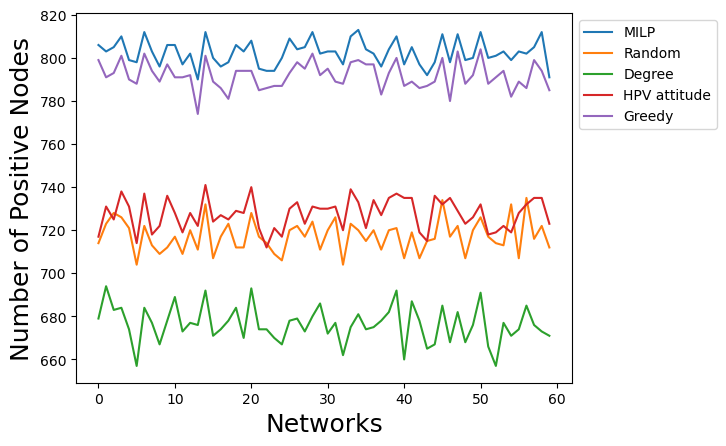

In [17]:
plt.plot(num_pos_optimization,label='MILP')
plt.plot(num_pos_random,label='Random')
plt.plot(num_pos_contact,label='Degree')
plt.plot(num_pos_highscore,label='HPV attitude')
plt.plot(num_pos_greedy,label='Greedy')
plt.legend(fontsize=18)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Networks',fontsize=18)
plt.ylabel('Number of Positive Nodes',fontsize=18)

plt.savefig('figures/optimizatoin_results_greedy.eps', bbox_inches="tight", format='eps',dpi=600)
plt.show()

In [35]:
initial_positives=np.zeros(60)
for i in range(60):
     for j in Network[i].G.nodes:
        if Network[i].G.nodes.data('initial attitude')[j]<12:
            initial_positives[i]+=1
initial_positives    

array([469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
       469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
       469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
       469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
       469., 469., 469., 469., 469., 469., 469., 469., 469., 469., 469.,
       469., 469., 469., 469., 469.])

In [47]:
num_pos_optimization[0]

806

### Who do we select?

In [52]:
def ttest(ms,mus,str_name,sol_file):
    var_ = [i for i in hpvdata[str_name].values]
    with open(sol_file, "rb") as file:
        soluniform = pickle.load(file)
    selected = []
    unselected =[]
    for i in range(len(var_)):
        if i in soluniform:
            if var_[i]>0:
                selected.append(var_[i])
        else:
            if var_[i]>0:
                unselected.append(var_[i])
    #print(str_name)
    test = stats.ttest_ind(selected, unselected)
    ms.append(np.mean(selected))
    mus.append(np.mean(unselected))
    if test.pvalue<0.01:
        print(stats.ttest_ind(selected, unselected))
        print(np.mean(selected))
        print(np.mean(unselected))
    return ms,mus
ms=[]
mus=[]
for i in range(60):
    ms,mus = ttest(ms,mus,'HPV_VAX_attitu_s35',"100_Network_Sols/sol_50_network"+str(i)+".pkl")

Ttest_indResult(statistic=7.74895886413574, pvalue=2.207531903156525e-14)
20.44
13.694416243654823
Ttest_indResult(statistic=7.392671571331474, pvalue=2.9679990334480073e-13)
20.16
13.708629441624366
Ttest_indResult(statistic=7.46879745350993, pvalue=1.7186434040923752e-13)
20.22
13.705583756345177
Ttest_indResult(statistic=6.863013274129655, pvalue=1.16070448953125e-11)
19.74
13.72994923857868
Ttest_indResult(statistic=9.976397409318281, pvalue=1.9276081818725371e-22)
22.14
13.608121827411168
Ttest_indResult(statistic=7.29135367492017, pvalue=6.09529566478834e-13)
20.08
13.712690355329949
Ttest_indResult(statistic=8.236872466815736, pvalue=5.305733696807704e-16)
20.82
13.6751269035533
Ttest_indResult(statistic=6.687660557088981, pvalue=3.707302384583055e-11)
19.6
13.737055837563451
Ttest_indResult(statistic=7.266056570592171, pvalue=7.285240569669132e-13)
20.06
13.713705583756346
Ttest_indResult(statistic=7.16499602892264, pvalue=1.4774568333095497e-12)
19.98
13.717766497461929
Ttest_

In [55]:
np.mean(mus)

13.705211505922168

In [54]:
np.mean(ms)

20.22733333333333

### budget vs. # pos

In [20]:
sample = 0

In [21]:
with open("Results_section/obj_optimization_base_varying_budget.pkl", "rb") as file:
    base_obj_optimization = pickle.load(file)

In [22]:
with open("Results_section/obj_random_base_varying_budget.pkl", "rb") as file:
    base_obj_random = pickle.load(file)

In [33]:
with open("Results_section/obj_greedy_base_varying_budget.pkl", "rb") as file:
    base_obj_greedy = pickle.load(file)

In [34]:
with open("Results_section/obj_contact_base_varying_budget.pkl", "rb") as file:
    base_obj_contact = pickle.load(file)

In [35]:
with open("Results_section/obj_highscore_base_varying_budget.pkl", "rb") as file:
    base_obj_highscore = pickle.load(file)

In [36]:
len(base_obj_greedy)

19

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


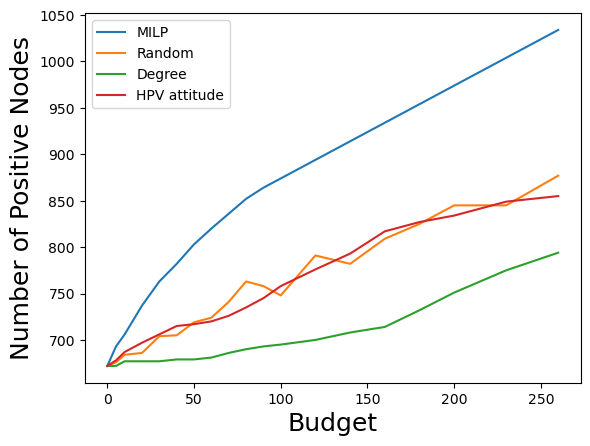

In [39]:
budgets = [0,5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,230,260,290,320,350]
plt.plot(budgets[:-3],base_obj_optimization[:-3],label='MILP')
plt.plot(budgets[:-3],base_obj_random[:-3],label='Random')
plt.plot(budgets[:-3],base_obj_contact[:-3],label='Degree')
plt.plot(budgets[:-3],base_obj_highscore[:-3],label='HPV attitude')
#plt.plot(budgets[:-3],base_obj_greedy,label='Greedy')
plt.legend()
plt.ylabel('Number of Positive Nodes',fontsize=18)
plt.xlabel('Budget',fontsize=18)
plt.savefig('figures/budgets.eps', bbox_inches="tight", format='eps',dpi=600)
